<a href="https://colab.research.google.com/github/Waxpple/ML4NASA21SENSOR/blob/master/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#REF:https://www.kaggle.com/nafisur/predictive-maintenance-using-lstm-on-sensor-data

In [1]:
#get file from nasa
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/train_FD001.txt
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/RUL_FD001.txt
!wget https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/test_FD001.txt

--2019-11-06 20:43:01--  https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/train_FD001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3515356 (3.4M) [text/plain]
Saving to: ‘train_FD001.txt.3’

train_FD001.txt.3   100%[===================>]   3.35M  --.-KB/s    in 0.08s   

2019-11-06 20:43:01 (41.4 MB/s) - ‘train_FD001.txt.3’ saved [3515356/3515356]

--2019-11-06 20:43:02--  https://raw.githubusercontent.com/Waxpple/ML4NASA21SENSOR/master/RUL_FD001.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 429 [text/plain]
Sav

In [2]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, LSTM, TimeDistributed, RepeatVector
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline

import os
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, LSTM
from keras.wrappers.scikit_learn import KerasClassifier

import scipy
from scipy.stats import norm

import boto3

# get rid of deprecated warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn import linear_model


import matplotlib as mlab
import matplotlib.pyplot as plt
mlab.rcParams['figure.figsize']=(17,10)

Using TensorFlow backend.


In [3]:
# get the training file and call its handler "train"
train = pd.read_csv('train_FD001.txt',sep=" " ,header = None)             
test = pd.read_csv('test_FD001.txt',sep =" ",header = None)


if train.empty:
    raise Exception('No data found!')
if test.empty:
    raise Exception('No test found!')
# remove some columns and add titles
train.drop(train.columns[[26,27]],axis=1,inplace=True)
test.drop(test.columns[[26,27]],axis=1,inplace=True)

operational_columns = ['setting1','setting2','setting3']
observational_columns = ['s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11','s12','s13','s14','s15','s16','s17','s18','s19','s20','s21']

train.columns = ['id','cycle'] + operational_columns + observational_columns 
test.columns = ['id','cycle'] + operational_columns + observational_columns 

#test = train
print(train.head())
print(test.head())

   id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1   -0.0007   -0.0004     100.0  ...  392  2388  100.0  39.06  23.4190
1   1      2    0.0019   -0.0003     100.0  ...  392  2388  100.0  39.00  23.4236
2   1      3   -0.0043    0.0003     100.0  ...  390  2388  100.0  38.95  23.3442
3   1      4    0.0007    0.0000     100.0  ...  392  2388  100.0  38.88  23.3739
4   1      5   -0.0019   -0.0002     100.0  ...  393  2388  100.0  38.90  23.4044

[5 rows x 26 columns]
   id  cycle  setting1  setting2  setting3  ...  s17   s18    s19    s20      s21
0   1      1    0.0023    0.0003     100.0  ...  392  2388  100.0  38.86  23.3735
1   1      2   -0.0027   -0.0003     100.0  ...  393  2388  100.0  39.02  23.3916
2   1      3    0.0003    0.0001     100.0  ...  393  2388  100.0  39.08  23.4166
3   1      4    0.0042    0.0000     100.0  ...  391  2388  100.0  39.00  23.3737
4   1      5    0.0014    0.0000     100.0  ...  390  2388  100.0  38.99  2

In [4]:
# prepare the dataset

LOOKBACK_LENGTH = 50 # number of cycles in the past to analyse on a rolling basis
DAYS_IN_ADVANCE = 30 # number of cycles we consider before the engine fail

# get the "truth" data file to be used as the test dataset and call it "truth"

##### TO BE COMPLETED #####                  
truth = pd.read_csv('RUL_FD001.txt',sep=" " ,header = None) 
print(truth.head())
truth.drop(truth.columns[[1]],axis=1,inplace=True)

# for a given engine, RUL = cycle at failure - current cycle
# we add this parameter as a column to the left of the training data table
# then we drop the max column that becomes useless
train.head()
rul = pd.DataFrame(train.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
train = train.merge(rul, on=['id'], how='left')

train['RUL'] = train['max'] - train['cycle']
train.drop('max', axis=1, inplace=True)

     0   1
0  112 NaN
1   98 NaN
2   69 NaN
3   82 NaN
4   91 NaN


In [5]:
print(train.head())


   id  cycle  setting1  setting2  setting3  ...   s18    s19    s20      s21  RUL
0   1      1   -0.0007   -0.0004     100.0  ...  2388  100.0  39.06  23.4190  191
1   1      2    0.0019   -0.0003     100.0  ...  2388  100.0  39.00  23.4236  190
2   1      3   -0.0043    0.0003     100.0  ...  2388  100.0  38.95  23.3442  189
3   1      4    0.0007    0.0000     100.0  ...  2388  100.0  38.88  23.3739  188
4   1      5   -0.0019   -0.0002     100.0  ...  2388  100.0  38.90  23.4044  187

[5 rows x 27 columns]


In [0]:
rul = pd.DataFrame(test.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id','max']
truth.columns = ['more']
truth['id'] = truth.index + 1
truth['max'] = rul['max'] + truth['more']
truth.drop('more',axis=1,inplace=True)

In [0]:
# generate test['RUL'] for test data using max and cycle

test = test.merge(truth, on=['id'], how='left')

test['RUL'] = test['max'] - test['cycle'] 
                 

test.drop('max', axis=1, inplace=True)

In [8]:
df_train=train.copy()
df_test=test.copy()
period=DAYS_IN_ADVANCE
df_train['label_bc'] = df_train['RUL'].apply(lambda x: 1 if x <= period else 0)
df_test['label_bc'] = df_test['RUL'].apply(lambda x: 1 if x <= period else 0)
df_train.head()

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,21.61,554.36,2388.06,9046.19,1.3,47.47,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,191,0
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,21.61,553.75,2388.04,9044.07,1.3,47.49,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,190,0
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,21.61,554.26,2388.08,9052.94,1.3,47.27,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,189,0
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,21.61,554.45,2388.11,9049.48,1.3,47.13,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,188,0
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,21.61,554.00,2388.06,9055.15,1.3,47.28,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,187,0


In [9]:
df_test.head(100)

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s11,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21,RUL,label_bc
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,21.61,553.90,2388.04,9050.17,1.3,47.20,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735,142,0
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,21.61,554.85,2388.01,9054.42,1.3,47.50,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916,141,0
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,21.61,554.11,2388.05,9056.96,1.3,47.50,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166,140,0
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,21.61,554.07,2388.03,9045.29,1.3,47.28,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737,139,0
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,21.61,554.16,2388.01,9044.55,1.3,47.31,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130,138,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,3,16,0.0021,-0.0000,100.0,518.67,642.38,1592.50,1400.05,14.62,21.61,553.44,2388.08,9050.60,1.3,47.53,520.93,2388.10,8127.71,8.4246,0.03,393,2388,100.0,38.92,23.3800,179,0
96,3,17,0.0003,0.0000,100.0,518.67,642.83,1588.45,1405.40,14.62,21.61,553.81,2388.07,9051.43,1.3,47.59,521.58,2388.15,8128.93,8.4287,0.03,392,2388,100.0,38.81,23.3644,178,0
97,3,18,0.0015,-0.0000,100.0,518.67,642.61,1581.11,1409.15,14.62,21.61,553.79,2388.10,9049.56,1.3,47.61,521.20,2388.08,8135.06,8.3918,0.03,393,2388,100.0,38.87,23.1391,177,0
98,3,19,0.0030,-0.0002,100.0,518.67,642.92,1587.40,1410.35,14.62,21.61,553.94,2388.13,9050.03,1.3,47.57,521.28,2388.09,8136.31,8.4564,0.03,393,2388,100.0,39.00,23.2953,176,0


In [0]:
features_col_name=['setting1', 'setting2', 'setting3', 's1', 's2', 's3', 's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11',
                   's12', 's13', 's14', 's15', 's16', 's17', 's18', 's19', 's20', 's21']
target_col_name='label_bc'

In [0]:
sc=preprocessing.MinMaxScaler()
df_train[features_col_name]=sc.fit_transform(df_train[features_col_name])
df_test[features_col_name]=sc.transform(df_test[features_col_name])

In [0]:
def gen_sequence(id_df, seq_length, seq_cols):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    lstm_array=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        lstm_array.append(data_array[start:stop, :])
    return np.array(lstm_array)

# function to generate labels
def gen_label(id_df, seq_length, seq_cols,label):
    df_zeros=pd.DataFrame(np.zeros((seq_length-1,id_df.shape[1])),columns=id_df.columns)
    id_df=df_zeros.append(id_df,ignore_index=True)
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    y_label=[]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        y_label.append(id_df[label][stop])
    return np.array(y_label)

In [13]:
seq_length=LOOKBACK_LENGTH
seq_cols=features_col_name
# generate X_train
X_train=np.concatenate(list(list(gen_sequence(df_train[df_train['id']==id], seq_length, seq_cols)) for id in df_train['id'].unique()))
print(X_train.shape)
# generate y_train
y_train=np.concatenate(list(list(gen_label(df_train[df_train['id']==id], 50, seq_cols,'label_bc')) for id in df_train['id'].unique()))
print(y_train.shape)

(20531, 50, 24)
(20531,)


In [14]:
# generate X_test
X_test=np.concatenate(list(list(gen_sequence(df_test[df_test['id']==id], seq_length, seq_cols)) for id in df_test['id'].unique()))
print(X_test.shape)
# generate y_test
y_test=np.concatenate(list(list(gen_label(df_test[df_test['id']==id], 50, seq_cols,'label_bc')) for id in df_test['id'].unique()))
print(y_test.shape)

(12996, 50, 24)
(12996,)


In [15]:
nb_features =X_train.shape[2]
timestamp=seq_length

model = Sequential()

model.add(LSTM(
         input_shape=(timestamp, nb_features),
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))

model.add(Dense(units=1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 50, 100)           50000     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 80,251
Trainable params

In [16]:
# fit the network
history = model.fit(X_train, y_train, epochs=10, batch_size=200, validation_split=0.05, verbose=1,
          callbacks = [EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='min')])




Train on 19504 samples, validate on 1027 samples
Epoch 1/10





19504/19504 [==============================] - 26s 1ms/step - loss: 0.1982 - acc: 0.9221 - val_loss: 0.0647 - val_acc: 0.9718
Epoch 2/10
19504/19504 [==============================] - 24s 1ms/step - loss: 0.0849 - acc: 0.9653 - val_loss: 0.0550 - val_acc: 0.9786
Epoch 3/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0666 - acc: 0.9711 - val_loss: 0.0408 - val_acc: 0.9844
Epoch 4/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0624 - acc: 0.9731 - val_loss: 0.0454 - val_acc: 0.9864
Epoch 5/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0649 - acc: 0.9717 - val_loss: 0.0496 - val_acc: 0.9825
Epoch 6/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0554 - acc: 0.9768 - val_loss: 0.0337 - val_acc: 0.9922
Epoch 7/10
19504/19504 [==============================] - 23s 1ms/step - loss: 0.0614 - acc: 0.9733 - val_loss: 0.0371 - 

Text(0.5, 1.0, 'Training and validation loss')

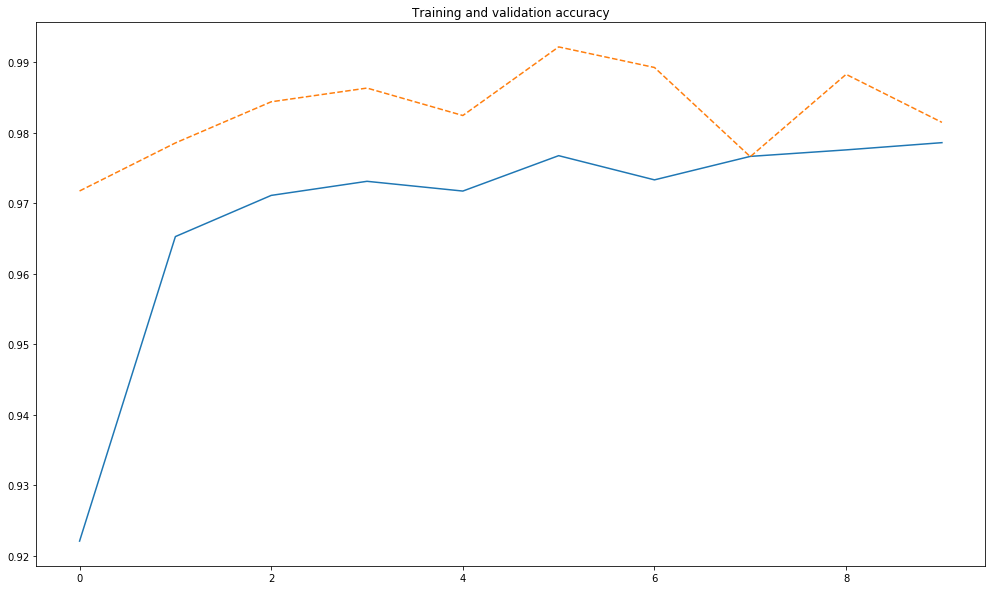

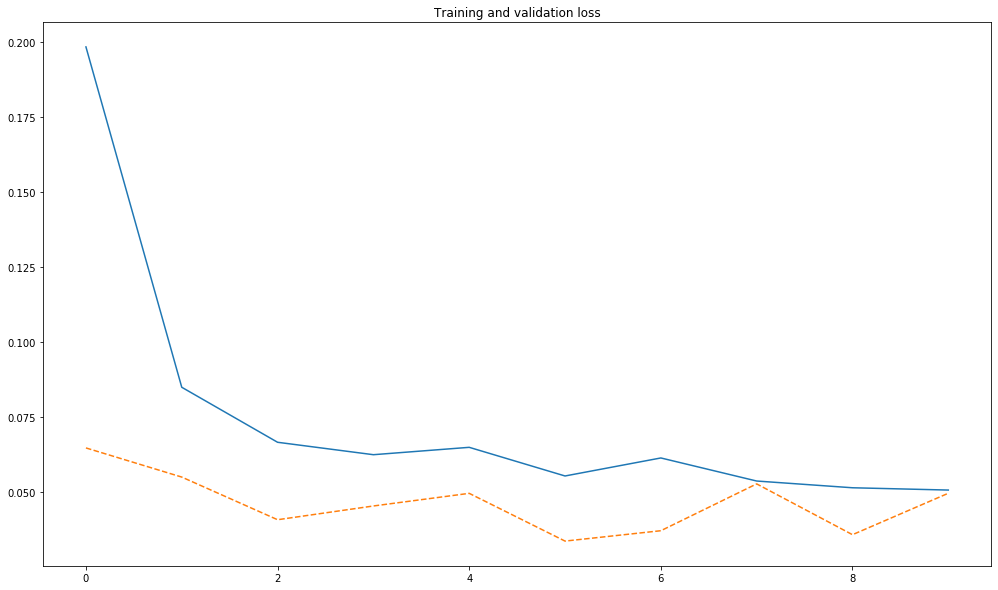

In [17]:
# Retrieve a list of accuracy results on training and validation data
# sets for each training epoch
acc = history.history['acc']
val_acc = history.history['val_acc']

# Retrieve a list of list results on training and validation data
# sets for each training epoch
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get number of epochs
epochs = range(len(acc))

# Plot training and validation accuracy per epoch
plt.plot(epochs, acc)
plt.plot(epochs, val_acc,linestyle='dashed',label='validation')
plt.title('Training and validation accuracy')

plt.figure()

# Plot training and validation loss per epoch
plt.plot(epochs, loss)
plt.plot(epochs, val_loss,linestyle='dashed')
plt.title('Training and validation loss')

In [18]:
# training metrics
scores = model.evaluate(X_train, y_train, verbose=2, batch_size=200)
print('Accurracy: {}'.format(scores[1]))

Accurracy: 0.9813452912116677


In [19]:
y_pred=model.predict_classes(X_test)
print('Accuracy of model on test data: ',accuracy_score(y_test,y_pred))
print('precision_score of model on test data: ',precision_score(y_test,y_pred))
print('recall_score of model on test data: ',recall_score(y_test,y_pred))
print('Confusion Matrix: \n',confusion_matrix(y_test,y_pred))

Accuracy of model on test data:  0.992305324715297
precision_score of model on test data:  0.9055944055944056
recall_score of model on test data:  0.7801204819277109
Confusion Matrix: 
 [[12637    27]
 [   73   259]]


In [0]:
def prob_failure(machine_id):
    machine_df=df_test[df_test.id==machine_id]
    machine_test=gen_sequence(machine_df,seq_length,seq_cols)
    m_pred=model.predict(machine_test)
    failure_prob=list(m_pred[-1]*100)[0]
    return failure_prob

In [21]:
machine_id=1
print('Probability that machine will fail within 30 days: ',prob_failure(machine_id))

Probability that machine will fail within 30 days:  0.0003529951
